### 3D U-Net Implementation
1. [Paper](https://arxiv.org/pdf/1606.06650.pdf)
2. [Implementation](https://github.com/wolny/pytorch-3dunet)

**3D U-Net deals with Biomedical "Volumetric" Data.**

**0. Contributions**
- Annotates some slices in the volume to be segmented.
- Dense segmentation even when trained with datasets that sparsely annotated training set exists.
- 3D counterpart implementatioin of 2D U-Net
- Elastic deformations for efficient data augmentation during training

**1. Related Works**
- 3D CNN Hough Voting Approach [Milletari et al.](https://www.researchgate.net/publication/336312306_Hough-CNN_Deep_Learning_for_Segmentation_of_Deep_Brain_Regions_in_MRI_and_Ultrasound)
    - Weakness : Not E2E
- 3D CNN E2E approach for 3D segmentation [Kleesiek et al.](https://pubmed.ncbi.nlm.nih.gov/26808333/)
    - Weakness : Not deep enough, only one pooling layer after first convolution >> multiple scale image segmentation is unavailable.
    
**2. Architecture and Details**
- Architecture
    - 3D version of 2D U-Net
    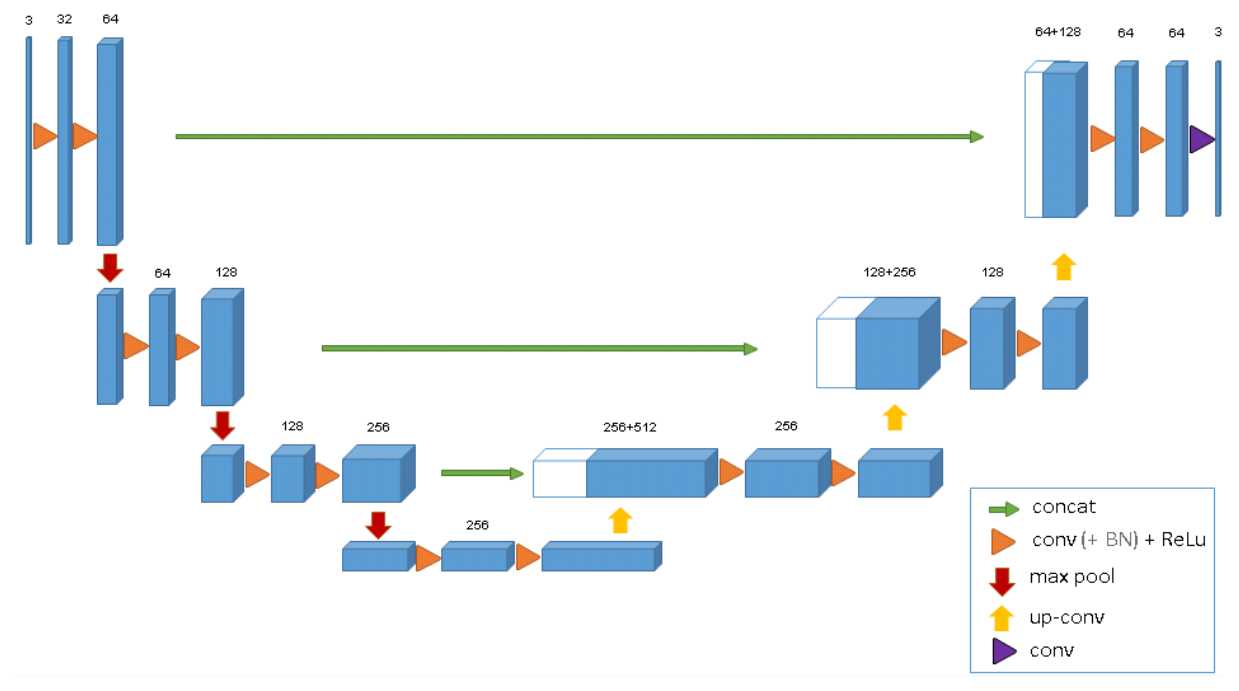
- Details
    - Inception v2 for bottleneck problem
    - BatchNorm for faster convergence
    - Elastic Deformation for data augmentation


### Implementation of various data augmentation methods

```python
# Reference: https://github.com/wolny/pytorch-3dunet/blob/master/pytorch3dunet/augment/transforms.py
import importlib
import random

import numpy as np
import torch
from scipy.ndimage import rotate, map_coordinates, gaussian_filter, convolve
from skimage import measure
from skimage.filters import gaussian
from skimage.segmentation import find_boundaries
```

**Define Compose Class**
``` python
GLOBAL_RANDOM_STATE = np.random.RandomState(47) # Code reproducibility when random augmentation
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, m): # call magic method, when this class is called -> this method will be executed.
        for t in self.transforms:
            m = t(m)
        return m
```

**1. Random Flip**

- Concepts <br/>
    - ```numpy.random.RandomState ``` <br/>
    - ```numpy.random.RandomState.uniform()``` <br/>
    - ```numpy.flip()``` <br/>
    - ```numpy.stack()``` <br/>
    - ```assert``` <br/>
    - ```kwargs``` <br/>

``` python
# Random Flip Implementation
class RandomFlip:
    '''
    randomly flip images across the given axes.
    3D or 4D image can also be flipped.
    '''
    
    def __init__(self, random_state, axis_prob = 0.5, **kwargs):
        assert random_state is not None, 'RandomState cannot be None'
        self.random_state = random_state
        self.axes = (0,1,2)
        self.axis_prob = axis_prob
        
    def __call__(self, m):
        assert m.ndim in [3,4], 'Supports only 3D(DxHxW) or 4D(CxDxHxW) images'
        
        for axis in self.axes:
            if self.random_state.uniform() > self.axis_prob:
                if m.ndim == 3:
                    m = np.flip(m, axis)
                else:
                    channels = [np.flip(m[c], axis) for c in range(m.shape[0])]
                    m = np.stack(channels, axis = 0)
        
        return m
```

**2. RandomRotate90, RandomRotate**
- Concepts
    - ```np.rot90()```
    - ```np.stack()```
    - ```scipy.ndimage.rotate()```
    - **$\text{__call__}$** magic method is invoked when the instance of a class is invoked. 

```python
class RandomRotate90:
    
    def __init__(self, random_state, **kwargs):
        self.random_state = random_state
        self.axis = (1,2) # always around z-axis
        
    def __call__(self, m):
        assert m.ndim in [3,4], 'Supports onlly 3D (DxHxw) or 4D(CxDxHxW) images'
        
        k = self.random_state.randint(0,4)
        if m.ndim == 3:
            m = np.rot90(m,k, self.axis)
            
        else:
            channels = [np.rot90(m[c], k, self.axis) for c in range(m.shape[0])]
            m = np.stack(channels, axis = 0)
            
        return m
```

``` python
class RandomRotate:
    ''' 
    Rotate an array by a random degree.
    '''
    def __init__(self, random_state, angle_spectrum = 30, axes = None, mode = 'reflect', order = 0, **kwargs):
        if axes is None:
            axes = [(1,0), (2,1), (2,0)]
        
        else:
            assert isinstance(axes, list) and len(axes) > 0
            # if axes is list format and axes has more than 1 elements, no error asserted
            
            self.random_state = random_state
            self.angle_spectrum = angle_spectrum
            self.axes = axes
            self.mode = mode
            self.order = order
            
    def __call__(self, m):
        axis = self.axes[self.random_state.randint(len(self.axes))] # select random axis
        angle = self.randome_state.randint(-self.angle_spectrum, self.angle_spectrum) # random angle
        
        if m.ndim == 3: # rotate : scipy.ndimage.rotate()
            m = rotate(m, angle, axes = axis, reshape = False, order = self.order, mode = self.mode, cval = -1)
        else: # for 4D(BatchXChannelsXHeightXWidth), iterate for all tensors in batch and stack them.
            channels = [rotate(m[c], angle, axes = axis, reshape = False, order = self.order, mode = self.mode, cval = -1) for c in range(m.shape[0])]
            m = np.stack(channels, axis = 0)
        
        return m
```

**3. Elastic Deformation**
- Concepts
    - ```guassian_filter()```
    - ```np.meshgrid()```
    - ```scipy.ndimage.map_coordinates()```
    
- How does elastic deformation works?
    For 2D,
    - $\Delta_x(n,m) = G(\sigma)*(\alpha \times Rand(n,m))$
    - $\Delta_y(n,m) = G(\sigma)*(\alpha \times Rand(n,m))$
    - $I_{trans} (j+\Delta_x (j,k), k+\Delta_y (j,k)) = I(j,k)$

```python
class ElasticDeformation:
    
    def __init__(
        self, random_state, spline_order, 
        alpha = 2000, sigma = 50, execution_probability = 0.1,
        **kwargs
    ):
        
        self.random_state = random_state
        self.spline_order = spline_order
        self.alpha = alpha
        self.sigma = sigma
        self.execution_probability = execution_probability
        self.apply_3d = apply_3d
    
    def __call__(self, m):
        if self.random_state.uniform() < self.execution_probability:
            assert m.ndim in [3,4]
            if m.ndim == 3:
                volume_shape = m.shape
            else:
                volume_shape = m[0].shape
            
            if self.apply_3d:# * unpacks tuples
                dz = gaussian_filter(self.random_state.randn(*volume_shape), self.sigma, mode="reflect") * self.alpha
            else:
                dz = np.zeros_like(m)
            
            dy, dx = [
                gaussian_filter(
                    self.random_state.randn(*volume_shape),
                    self.sigma, mode = "reflect"
                ) * self.alpha for _ in range(2)
            ]
            
            z_dim, y_dim, x_dim = volume_shape
            z, y, x = np.meshgrid(np.arange(z_dim), np.arange(y_dim), np.arange(x_dim), indexing = 'ij')
            indices = z+dz, y+dy, x+dx
            
            if m.ndim == 3:
                return map_coordinates(m, indices, order = self.spline_order, mode = 'reflect')
            else;
                channels = [map_coordinates(c, indices, order = self.spline_order, mode = 'reflect') for c in m]
                return np.stack(channels, axis = 0)
        
        return m
```

### Implementation of 3D U-Net
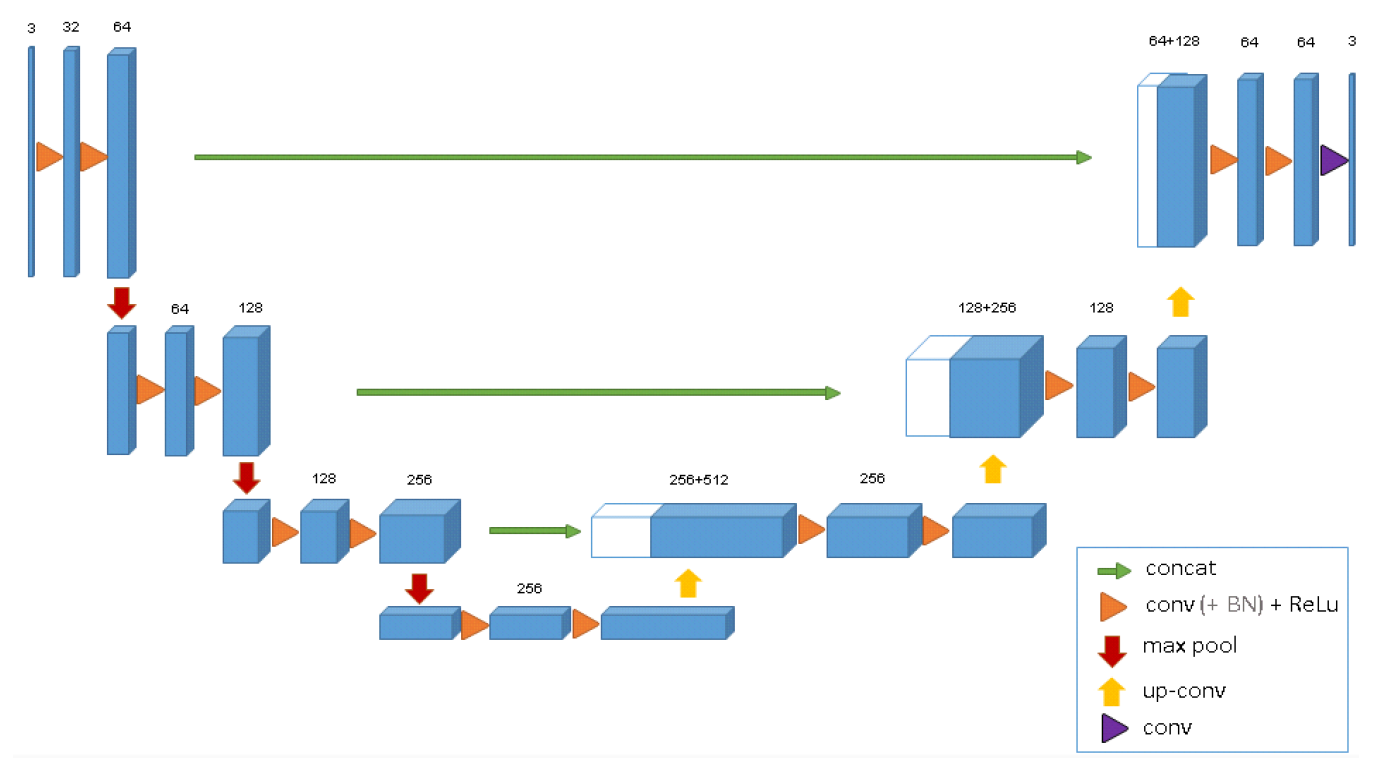

- **Concepts**
    - BatchNorm vs GroupNorm
    - Activation Functions : ELU, GeLU, ReLU, LeakyReLU
   
- **BatchNorm vs GroupNorm**
    - BN is effective component in DL.
    - BN normalized the feature by mean, variance within a 'batch'.
    - Normalizing along 'batch dimension' : in small batch size, BN leads to inaccurate estimation of batch statistics.
    - Thus, in such cases, GN can be a alternative to BN.
    - GN divieds the 'channels', not batches into groups & computes with each group the mean & variance for normalization.
    - Since GN computation is independent of batch sizes, thus accuracy is stable in a wide range of batch sizes.
    - Remark : Batch Size = Images/Worker
    - *Other Normalization Techs : Layer Normalization, Instance Normalization*
    <img src= "https://amaarora.github.io/images/GN_BN_LN_IN.png" width = "500dp"></img>

### Import Packages
```python
# Reference: https://github.com/wolny/pytorch-3dunet/tree/master/pytorch3dunet/unet3d
from functools import partial

import torch
from torch import nn as nn
from torch.nn import functional as F
```

### 3D Convolution Layer
```python
def conv3d(in_channels, out_channels, kernel_size, bias, padding):
    return nn.Conv3d(in_channels, out_channels, kernel_size, padding = padding, bias = bias)
```
### Variations of Convolution Layer

order notation : 'r', 'l', 'e', 'c', 'g' combination leads to stacks of layers. <br/>

- 'cr' : Conv+ReLU
- 'gcr' : GroupNorm + Conv + ReLU      
- 'cl' : Conv+LeakyReLU
- 'ce' : Conv+ELU
- 'bcr' : BatchNorm + Conv + ReLU
     
```python
def create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding):
    assert 'c' in order, "Conv Layer MUST BE PRESENT"
    assert order[0] not in 'rle', 'Non-linearlity cannot be the first operation in the layer'
    modules = []
    for i, char in enumerate(order):
        if char == 'r':
            modules.append(('ReLU', nn.ReLU(inplace = True)))
        elif char == 'l':
            modules.append(('LeakyReLU', nn.LeakyRELU(inplace = True)))
        elif char == 'e': # ELU : Exponential Linear Unit. cf. GELU
            modules.append(('ELU', nn.ELU(inplace = True)))
        elif char == 'c':
            # if 'g' in order or 'b' in order(normalization layer in order), bias = False
            # else, bias = True
            bias = not ('g' in order or 'b' in order)
            modules.append(('conv', cov3d(in_channels, out_channels, kernel_size, bias, padding = padding)))
        elif char == 'g':
            # if 'g' appears before than 'c' , normalization layer #channels = in_channels
            is_before_conv = i < order.index('c')
            if is_before_conv : 
                num_channels = in_channels
            else:
                num_channels = out_channels
            if num_channels < num_groups:
                num_groups = 1
            assert num_channels % num_groups == 0, f'Expected number of channels in input to be divisible by num_groups. num_channels={num_channels}, num_groups={num_groups}'
            modules.append(('groupnorm', nn.GroupNorm(num_groups = num_groups, num_channels = num_channels)))
        elif char == 'b':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                modules.append(('batchnorm', nn.BatchNorm3d(in_channels)))
            else:
                modules.append(('batchnorm', nn.BatchNorm3d(out_channels)))
        else:
            raise ValueError(f"Unsupported layer type '{char}'. MUST be one of ['b', 'g', 'r', 'l', 'e', 'c']")
        
    return modules
```

**Remark. Method Overriding**
- $\text{super().__init__() vs super(MyClass,self).__init__()}$ <br/>
- Explicit & Implicit notation difference, no sematic difference.


### UNet basic block & ResUNet basic block
``` python
class SingleConv(nn.Sequential): #Inheritance : nn.Sequential
    # Order : Group Normalization -> Conv -> ReLU
    def __init__(self, in_channels, out_channels, kernel_size = 3, order = 'gcr', num_groups = 8, padding = 1):
        super(SingleConv, self).__init__() # equivalent with super().__init__()
        
        for name, module in create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding = padding):
            self.add_module(name, module) # add_module is a method of nn.Sequential

class DoubleConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, encoder, kernel_size=3, order = 'gcr', num_groups = 8, padding = 1):
        super(DoubleConv, self).__init__() # equivalent with super().__init__()
        if encoder:
            conv1_in_channels = in_channels
            conv1_out_channels = out_channels // 2
            if conv1_out_channels < in_channels:
                conv1_out_channels = in_channels
            conv2_in_channels, conv2_out_channels = conv1_out_channels, out_channels
        else:
            conv1_in_channels, conv1_out_channels = in_channels, out_channels
            conv2_in_channels, conv2_out_channels = out_channels, out_channels
        self.add_module('SingleConv1', #Conv1
                        SingleConv(conv1_in_channels, conv1_out_channels, kernel_size, order, num_groups,
                                   padding=padding))
        self.add_module('SingleConv2', #Conv2
                        SingleConv(conv2_in_channels, conv2_out_channels, kernel_size, order, num_groups,
                                   padding=padding))
```  
### Variation of DoubleConv Block : ExtResNetBlock()
- Use ELU instead of ReLU('cge' order, instead of 'gcr')
- Useful Technical Paper : https://arxiv.org/pdf/1706.00120.pdf
- ResUNet fashion block, but why group normalization 'after' convolution?
``` python
class ExtResNetBlock(nn.Module)
    def __init__(self, in_channels, out_channels, kernel_size = 3, order = 'cge', num_groups = 8, **kwargs):
        super(ExtResNetBlock, self).__init__()
        
        self.conv1 = SingleConv(in_channels, out_channels, kernel_size = kernel_size, order = order, num_groups = num_groups)
        self.conv2 = SingleConv(out_channels, out_channels, kernel_size = kernel_size, order = order, num_groups = num_groups)
        # for 3rd block, remove non-linearity since it's gonna be concatenated first.
        n_order = order
        for c in 'rel':
            n_order = n_order.replace(c,'')
        self.conv3 = SingleConv(out_channels, out_channels, kernel_size = kernel_size, order = n_order, num_groups = num_groups)
        # then create non-linearity separately
        if 'l' in order:
            self.non_linearity = nn.LeakyReLU(negative_slope = 0.1, inplace = True)
        elif 'e' in order:
            self.non_linearity = nn.ELU(inplace = True)
        else:
            self.non_linearity = nn.ReLU(inplace = True)
    def forward(self, x):
        out = self.conv1(x)
        residual = out
        out = self.conv2(out)
        out = self.conv3(out)
        
        out += residual #its dimension are comaptible because conv2, conv3 layer does not change dimensionality.
        out = self.non_linearity(out)
        
        return out       
```